In [1]:
# Install required packages for word clouds and sentiment analysis
%pip install wordcloud textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.6/27.6 MB 2.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.4/793.4 kB 2.4 MB/s eta 0:00:00a 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.9.4-cp311-cp311-linux_aarch64.whl size=182550 sha256=f723d821e4d4ce68ef689ab4d3df80dc1ed7c2336bfade37437a09572dd46497
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/46/40/0e8bd59213d60c488378ff39099cc45cb114bcb6f8cdd84232
Successfully built wordcloud
Note: you may need to restart the kernel to use updated packages.


## Connect to Dremio

Connect to Dremio using PyArrow Flight with Basic authentication.

In [2]:
from pyarrow import flight
import pyarrow as pa

# Dremio Flight endpoint - use 'dremio' hostname inside Docker
DREMIO_HOST = "dremio"
DREMIO_PORT = 32010
DREMIO_USER = "dremio"
DREMIO_PASS = "dremio123"

# Create Flight client with Basic auth
client = flight.FlightClient(f"grpc+tcp://{DREMIO_HOST}:{DREMIO_PORT}")

# Authenticate with basic auth
token_pair = client.authenticate_basic_token(DREMIO_USER, DREMIO_PASS)
print(f"Connected to Dremio at {DREMIO_HOST}:{DREMIO_PORT}")

# Helper function to query Dremio
def query_dremio(sql_query):
    """Execute SQL query against Dremio and return pandas DataFrame"""
    options = flight.FlightCallOptions(headers=[token_pair])
    flight_info = client.get_flight_info(
        flight.FlightDescriptor.for_command(sql_query),
        options
    )
    reader = client.do_get(flight_info.endpoints[0].ticket, options)
    return reader.read_pandas()

Connected to Dremio at dremio:32010


## Load product_reviews as a pandas DataFrame
- Query Dremio from Python using PyArrow flight
- Load the query results to a Pandas DataFrame

In [3]:
# Query product reviews from the Silver layer
sql = """
SELECT 
    customer_id,
    review_id,
    review_date,
    rating,
    review_text,
    vehicle_model
FROM catalog.silver.product_reviews
WHERE review_text IS NOT NULL
"""

product_reviews = query_dremio(sql)
print(f"Loaded {len(product_reviews)} product reviews")
print(product_reviews.head())

Loaded 50 product reviews
  customer_id review_id review_date  rating  \
0        1966   REV2069  2021-03-16       4   
1         445   REV4626  2022-10-11       5   
2        2019   REV1804  2022-07-15       4   
3        2174   REV1565  2020-09-12       5   
4         771   REV7346  2021-05-01       3   

                                         review_text vehicle_model  
0  "We recently purchased the AeroFlow, and it's ...      AeroFlow  
1  I recently purchased the PowerRide EV, and I m...     PowerRide  
2  The UrbanGlide electric vehicle offers a sleek...    UrbanGlide  
3  I recently purchased the PowerRide, and it has...     PowerRide  
4  Title: Promising, yet Falls Short - The TerraC...    TerraCross  


## Basic Statistics
- Run basic statistics on the product_reviews DataFrame

In [4]:
print(product_reviews.describe())
print(product_reviews['vehicle_model'].value_counts())

          rating
count  50.000000
mean    4.200000
std     0.638877
min     3.000000
25%     4.000000
50%     4.000000
75%     5.000000
max     5.000000
vehicle_model
UrbanGlide    19
PowerRide     11
AeroFlow       9
TerraCross     6
EcoSprint      5
Name: count, dtype: int64


## Advanced Analytics
Run advanced analytics and machine learning on the product_reviews Dataset:

1. Wordclouds per vehicle model
2. Reviews sentiment analysis
3. Sentiment over time and sentiment distribution accros several categories

### Wordclouds per vehicle model

In [5]:
# wordcloud already installed in first cell

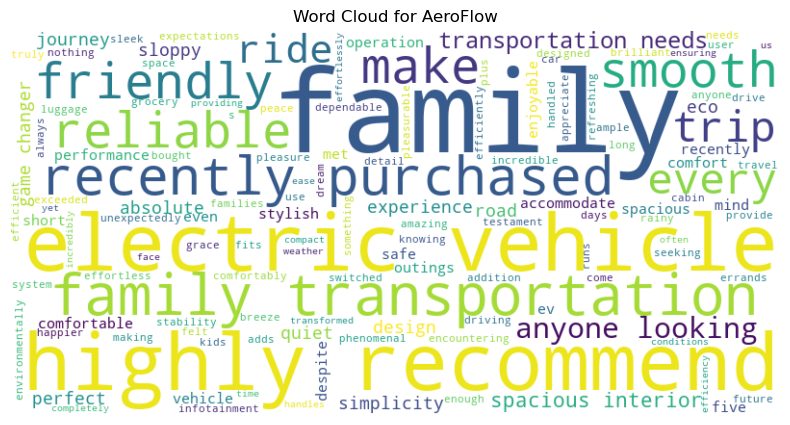

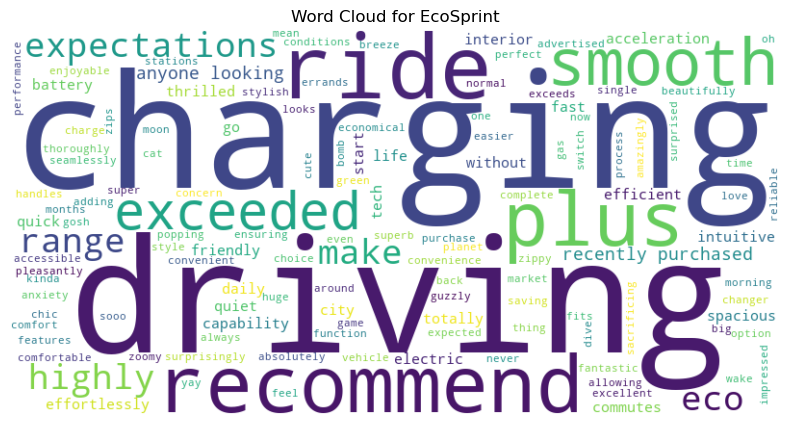

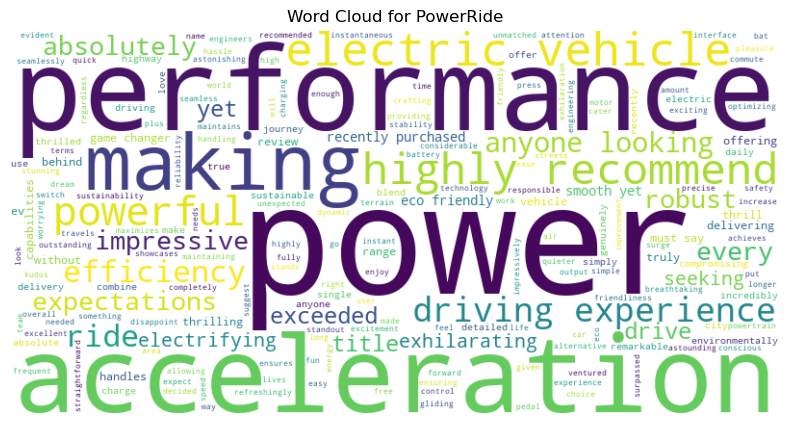

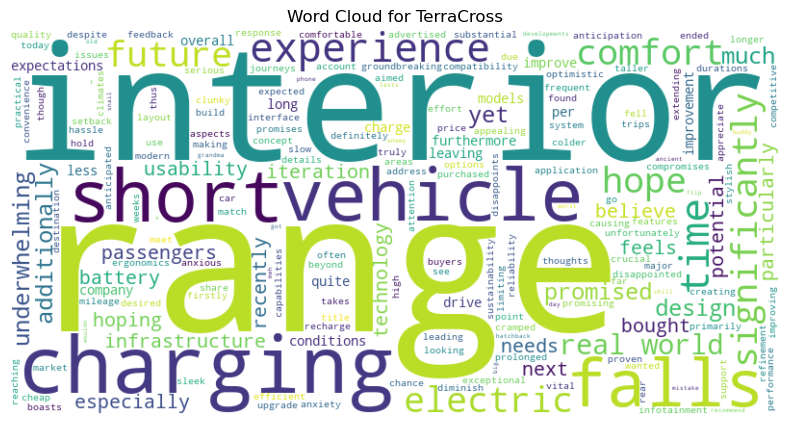

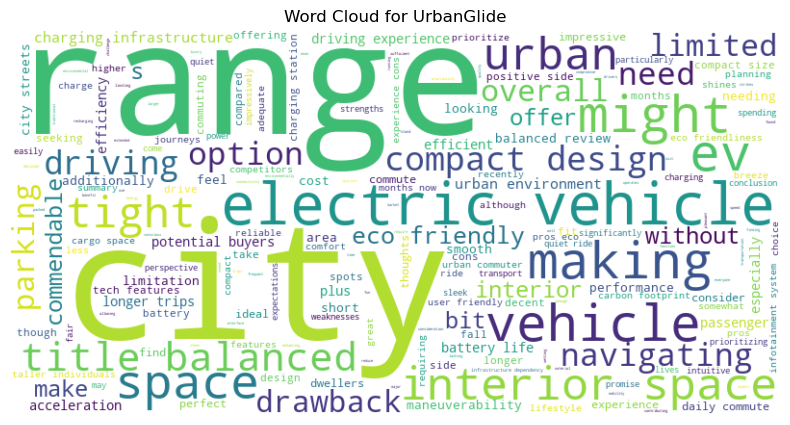

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# List of vehicle models to exclude from word clouds
vehicle_models = product_reviews['vehicle_model'].unique().tolist()

# Function to preprocess and clean text
def preprocess_text(text, vehicle_models):
    for model in vehicle_models:
        text = re.sub(model, '', text, flags=re.IGNORECASE)
    return text.lower()

# Apply the preprocessing function
product_reviews['clean_review_text'] = product_reviews['review_text'].apply(
    lambda x: preprocess_text(x, vehicle_models) if x else ''
)

# Function to create a word cloud
def create_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Aggregate review text by vehicle model
grouped_reviews = product_reviews.groupby('vehicle_model')['clean_review_text'].apply(' '.join)

# Create word clouds for each vehicle model
for model, text in grouped_reviews.items():
    if text.strip():  # Only create if there's text
        create_word_cloud(text, f'Word Cloud for {model}')

### Sentiment analysis per vehicle model

In [7]:
# textblob already installed in first cell

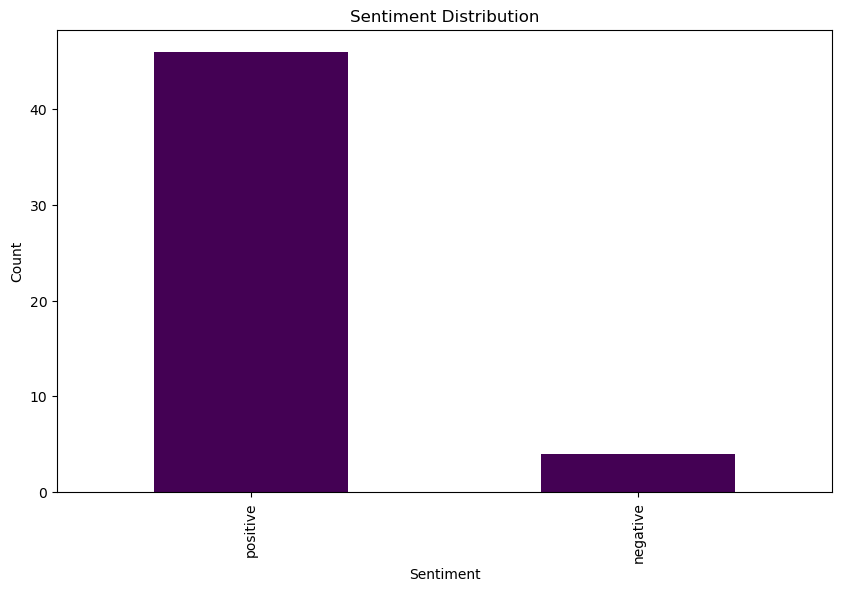

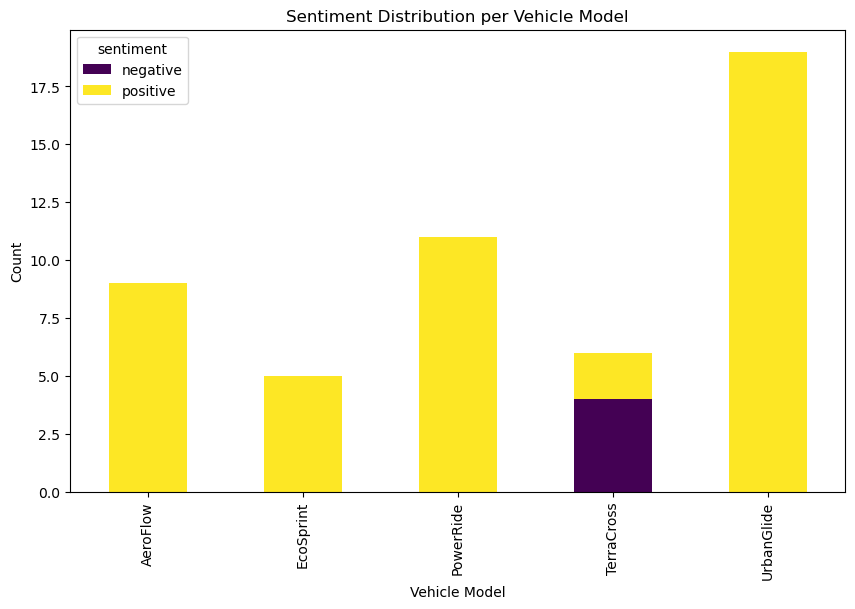

In [8]:
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt

# Sentiment analysis using TextBlob
def get_sentiment(text):
    if not text:
        return 'neutral'
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'

product_reviews['sentiment'] = product_reviews['review_text'].apply(get_sentiment)

# Distribution of sentiments
sentiment_counts = product_reviews['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Distribution of sentiments per vehicle model
sentiment_per_model = product_reviews.groupby('vehicle_model')['sentiment'].value_counts().unstack().fillna(0)
sentiment_per_model.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Sentiment Distribution per Vehicle Model')
plt.xlabel('Vehicle Model')
plt.ylabel('Count')
plt.show()

### Setiment over time

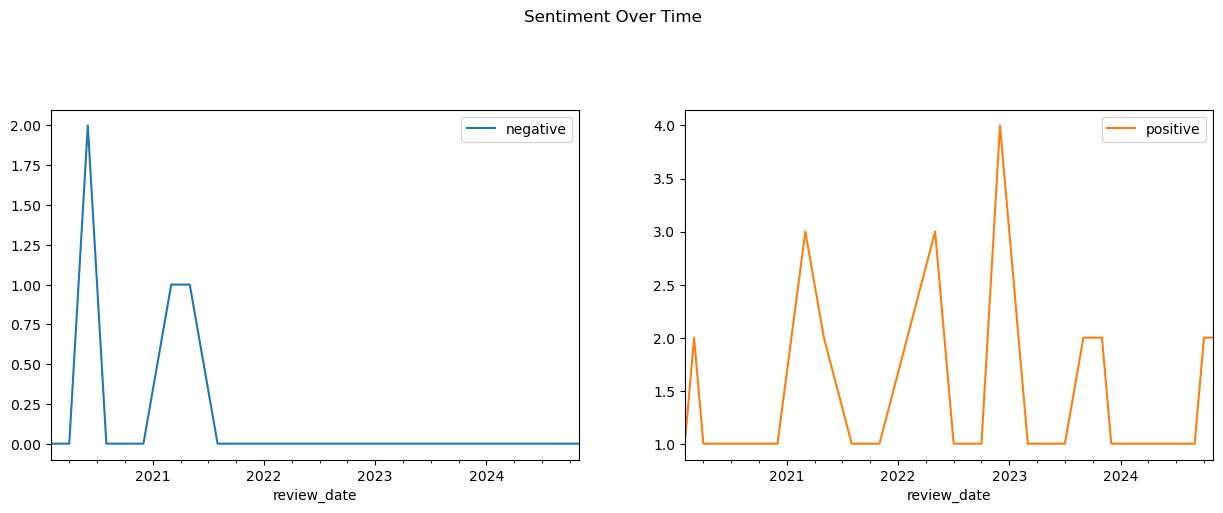

In [9]:
product_reviews['review_date'] = pd.to_datetime(product_reviews['review_date'])
sentiment_over_time = product_reviews.groupby([product_reviews['review_date'].dt.to_period('M')])['sentiment'].value_counts().unstack().fillna(0)
sentiment_over_time.plot(kind='line', subplots=True, layout=(2, 2), figsize=(15, 10), title="Sentiment Over Time")
plt.show()

### Get customer_segmentation dataset from the Lakehouse
- Load `customer_segmentation` as a Pandas DataFrame
- Join `customer_segmentation` with `product_reviews` on `customer_id`

In [10]:
# Query customer segmentation from the Gold layer
sql = """
SELECT 
    customer_id,
    first_name,
    city,
    state,
    country,
    total_purchases,
    average_purchase_value,
    preferred_models
FROM catalog.gold.customer_segmentation
WHERE customer_id IS NOT NULL
"""

customer_segmentation = query_dremio(sql)
print(f"Loaded {len(customer_segmentation)} customer segments")
print(customer_segmentation.head())

Loaded 2500 customer segments
  customer_id first_name             city           state        country  \
0         257      Jyoti  Port Washington        New York  United States   
1         208     Gwenny      San Antonio           Texas  United States   
2        1686     Aleece         Columbia  South Carolina  United States   
3        1781      Jamie      Springfield        Missouri  United States   
4         433  Thorndike           Mobile         Alabama  United States   

   total_purchases  average_purchase_value                  preferred_models  
0                2              66775.1300             EcoSprint, TerraCross  
1                5              51905.8920  EcoSprint, PowerRide, TerraCross  
2                1              89540.9100                         PowerRide  
3                2              69166.1450             PowerRide, TerraCross  
4                4              69381.2025  TerraCross, PowerRide, EcoSprint  


In [11]:
# Ensure customer_id is of the same type for merging
customer_segmentation['customer_id'] = customer_segmentation['customer_id'].astype(int)
product_reviews['customer_id'] = product_reviews['customer_id'].astype(int)

# Merge the datasets on customer_id
merged_df = pd.merge(product_reviews, customer_segmentation, on='customer_id')

print(f"Merged dataset: {len(merged_df)} rows")
print(merged_df.head())

Merged dataset: 50 rows
   customer_id review_id review_date  rating  \
0         1966   REV2069  2021-03-16       4   
1          445   REV4626  2022-10-11       5   
2         2019   REV1804  2022-07-15       4   
3         2174   REV1565  2020-09-12       5   
4          771   REV7346  2021-05-01       3   

                                         review_text vehicle_model  \
0  "We recently purchased the AeroFlow, and it's ...      AeroFlow   
1  I recently purchased the PowerRide EV, and I m...     PowerRide   
2  The UrbanGlide electric vehicle offers a sleek...    UrbanGlide   
3  I recently purchased the PowerRide, and it has...     PowerRide   
4  Title: Promising, yet Falls Short - The TerraC...    TerraCross   

                                   clean_review_text sentiment first_name  \
0  "we recently purchased the , and it's been ama...  positive     Ludvig   
1  i recently purchased the  ev, and i must say, ...  positive     Sandra   
2  the  electric vehicle offers a s

### Sentiment by State

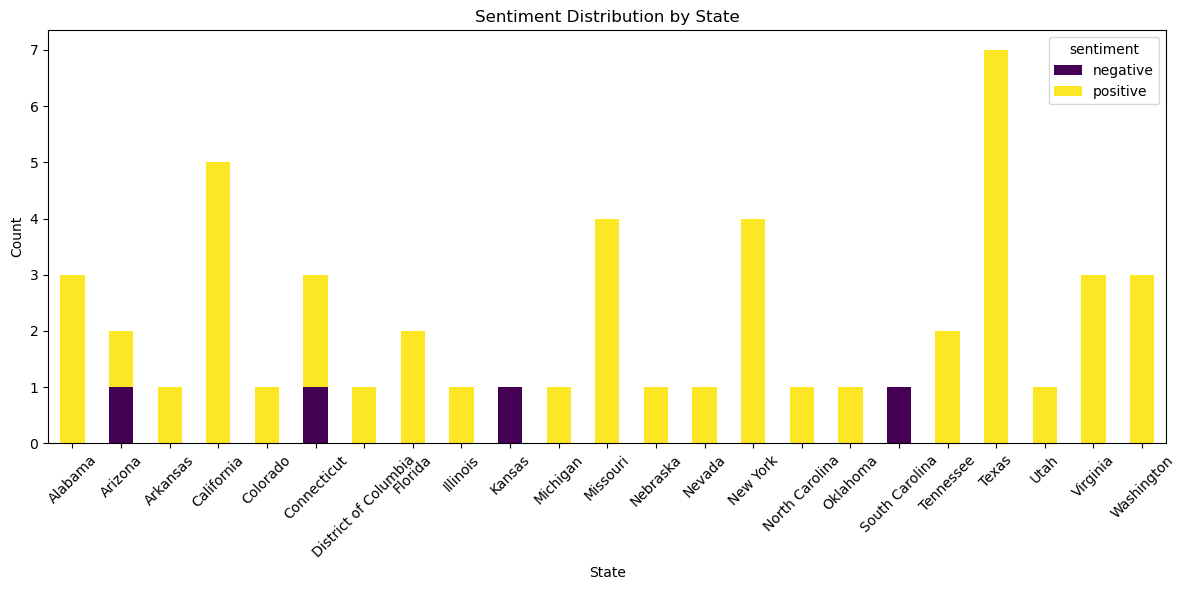

In [12]:
sentiment_by_state = merged_df.groupby('state')['sentiment'].value_counts().unstack().fillna(0)
sentiment_by_state.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Sentiment Distribution by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sentiment by VIP status

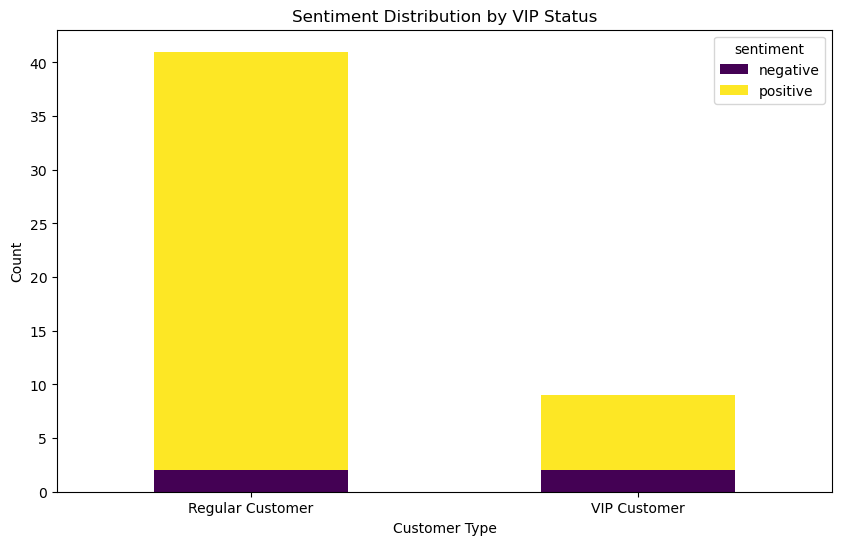

In [13]:
# Add is_vip column based on total_purchases (VIP = more than 3 purchases)
merged_df['is_vip'] = merged_df['total_purchases'] > 3
sentiment_by_vip = merged_df.groupby('is_vip')['sentiment'].value_counts().unstack().fillna(0)

# Create better labels
sentiment_by_vip.index = ['Regular Customer', 'VIP Customer']
sentiment_by_vip.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Sentiment Distribution by VIP Status')
plt.xlabel('Customer Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()